# Problem 1

### Classes to implement k-means

In [1]:
import random

class Point:
  def __init__(self, attrs, id=None, cluster=None):
    self.attrs = attrs
    if id is not None:
      self.id = id
    self.id = -1
    self.cluster = None

  def __getitem__(self, i):
    return self.attrs[i]

  def __getattr__(self, attr):
    if attr == 'x':
      return self.attrs[0]
    elif attr == 'y':
      return self.attrs[1]
    elif attr == 'attrs':
      return self.attrs
    elif attr == 'id':
      return self.id
    elif attr == 'cluster':
      return self.cluster

  def dist_to(self, other):
    the_sum = 0
    for i in range(len(self.attrs)):
      # if (type(self.attrs[i]) is int or type(self.attrs[i]) is float)\
      #     and (type(other.attrs[i] is int or type(other.attrs[i] is float))):
        the_sum += (self.attrs[i] - other.attrs[i]) ** 2
    return the_sum ** 0.5

  def setCluster(self, cluster):
    self.cluster = cluster.id

  def __repr__(self):
    return str(self.attrs)

  @staticmethod
  def _parseNum(num):
    split = num.split('E')
    return float(split[0]) * 10 ** int(split[1])

  @staticmethod
  def parseCoord(coord):
    x = Point._parseNum(coord[0])
    y = Point._parseNum(coord[1])

    return [x, y]
  
  def __eq__(self, other):
    if len(self.attrs) != len(other.attrs):
      return False
    
    for i in range(len(self.attrs)):
      if (type(self.attrs[i]) is int or type(self.attrs[i]) is float)\
          and (type(other.attrs[i] is int or type(other.attrs[i] is float))):
          if self.attrs[i] != other.attrs[i]:
            return False

    return True

  
  def __ne__(self, other):
    return not self == other


class Cluster:
  def __init__(self, center, id, points=None):
    self.center = center
    if points is not None:
      self.points = points
    else:
      self.points = []

    self.id = id
  def reCalcCenter(self):
    if len(self.points) == 0:
      return
    var_sum = [0 for _ in self.center.attrs]

    for p in self.points:
      for i in range(len(p.attrs)):
        var_sum[i] += p[i]
    
    new_attrs = [var_sum[i] / len(self.points) for i in range(len(self.center.attrs))]

    self.center = Point(new_attrs)
  
  def clear(self):
    self.points.clear()

  def addPoint(self, point):
    self.points.append(point)
  
  def remPoint(self, point):
    for i, p in enumerate(self.points):
      if p == point:
        del self.points[i]
        return True
    return False

  def __repr__(self):
    return str(self.center)


def getMinMax(points):
  minMax = [[None, None] for _ in range(len(points[0].attrs))]

  for p in points:
    for i, a in enumerate(p.attrs):
      if minMax[i][0] is not None and a < minMax[i][0]:
        minMax[i][0] = a
      elif minMax[i][0] is None:
        minMax[i][0] = a

      if minMax[i][1] is not None and minMax[i][1] < a:
        minMax[i][1] = a
      elif minMax[i][1] is None:
        minMax[i][1] = a
      
  return minMax


## Visualization

In [2]:
from PIL import Image, ImageDraw, ImageFont

def plot_points(points, fill='blue', image=None, pRange=None, label=None, axis=False):
    if pRange is None:
      minX = min([p.x for p in points])
      maxX = max([p.x for p in points])
      minY = min([p.y for p in points])
      maxY = max([p.y for p in points])

    else:
      minX = pRange[0]
      maxX = pRange[1]
      minY = pRange[2]
      maxY = pRange[3]

    size = 800
    xRange = max(maxX - minX, 0.01)
    yRange = max(maxY - minY, 0.01)

    padding = [20, 20, 20, 20] # top, right, bottom, left
    if axis:
      padding = [70, 10, 10, 70]

    axisSize = [45, 65] # [x axis height, y axis width]
    
    xExp = (size - (padding[1] + padding[3])) / xRange
    yExp = (size - (padding[0] + padding[2])) / yRange

    offsetX = padding[3]
    offsetY = padding[0]

    for p in points:
      p.x -= minX
      p.y -= minY
    
    radius = 5
    if image is None:
        image = Image.new("RGB", (size, size))
   
    draw = ImageDraw.Draw(image)

    font = ImageFont.truetype('arial.ttf', 20)
    if label is not None:
      draw.text((offsetX + xExp * points[0].x - 30, offsetY + yExp * points[0].y + 15), label, fill=fill, font=font)


    if axis:
      ## Axis lines
      # X Axis
      draw.line(((axisSize[1], axisSize[0]), (axisSize[1], size)), fill='white', width=5)
      draw.line(((axisSize[1], axisSize[0]), (size, axisSize[0])), fill='white', width=5)
      for i in range(axisSize[0], 801, 100):
        ## X Axis Labels and Ticks
        if i == axisSize[0]:
          continue
        draw.line(((i, axisSize[0]), (i, axisSize[0] + 5)), fill='white')
        draw.text((i - 22, axisSize[0] - 22), "{:.3f}".format((i - axisSize[0]) / xExp), font=font)

      
      for i in range(axisSize[1], 801, 100):
        ## Y Axis Label and Ticks
        draw.line(((axisSize[1], i), (axisSize[1], i)), fill='white')
        draw.text((1, i - 10), "{:.3f}".format((i - axisSize[1]) / yExp), font=font)

      # Axis Labels
      draw.text((0, size - 20), 'Width', font=font)
      draw.text((size - 70, axisSize[0] - 40), "Length", font=font)
  
    for p in points:
        draw.ellipse((offsetX + xExp * p.x - radius,
                      offsetY + yExp * p.y - radius,
                      offsetX + xExp * p.x + radius,
                      offsetY + yExp * p.y + radius), fill=fill)

    return image, [minX, maxX, minY, maxY]


## K-Means

In [3]:
def kmeans(points, num_clusters, plot=False):
  """
  Group points into n clusters (num_clusters) using k-means
  points: Points to be clustered
  num_clusters: Number of clusters
  plot: If true will plot the clusters after every iteration, false will do nothing
  """
  minMax = getMinMax(points)
  clusters = []

  # Generate Random Clusters
  for i in range(num_clusters):
    attrs = []
    for key in range(len(points[0].attrs)):
      # attrs.append(0)
      attrs.append(random.uniform(minMax[key][0], minMax[key][1]))

    clusters.append(Cluster(Point(attrs), i))

  # Iterate until no changes in data
  while True:
    for p in points:
      min_dist = None
      min_clust_index = None
      for i, c in enumerate(clusters):
        dist = p.dist_to(c.center)

        if min_dist is None or dist < min_dist:
          min_dist = dist
          min_clust_index = i
      clusters[min_clust_index].addPoint(p)

    anyChange = False
    for i, c in enumerate(clusters):
      oldCenter = c.center
      c.reCalcCenter()
      if oldCenter != c.center:
        anyChange = True

    if not anyChange:
      break
    else:
      # Clears all data in clusters for another iteration
      [c.clear() for c in clusters]

  return clusters

def predict(clusters, example):
 
  min_dist = None
  min_clust_index = None
  for i, c in enumerate(clusters):
    dist = example.dist_to(c.center)

    if min_dist is None or dist < min_dist:
      min_dist = dist
      min_clust_index = i
  
  return min_clust_index


## Run K-Means on cluster_data.txt and display results

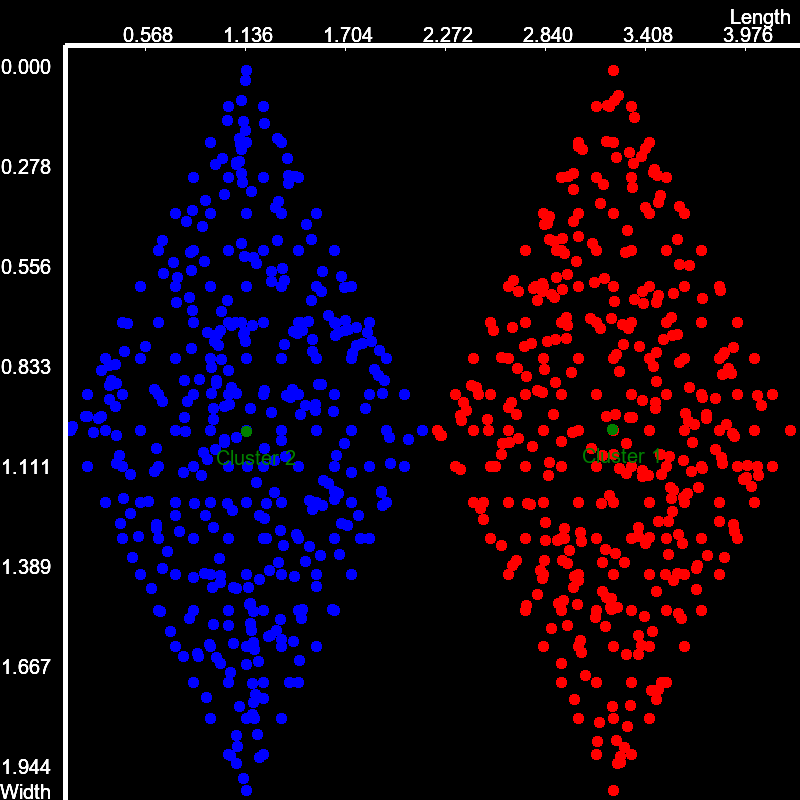

In [4]:
def getPointsFromFile(file):

  with open(file, 'r') as theFile:
    points = []
    split = theFile.read().split('\n') 
    for line in split:
      if line != '':
        point_split = line.split('\t')
        point = Point(Point.parseCoord(point_split[1:]), int(point_split[0]))
        points.append(point)
    return points


points = getPointsFromFile('./data/cluster_data.txt') # Loads points from Fil
# Points are in format [Point(x,y), Point(x,y), ..., Point(x,y)]
# Where Point is a point object defined at the top of the file\
minX = min([p.x for p in points])
maxX = max([p.x for p in points])
minY = min([p.y for p in points])
maxY = max([p.y for p in points])
pRange = [minX, maxX, minY, maxY] # Gets maximum and minimum values to plot effectively
clusters = kmeans(points, 2) # Runs K-Means


## Code below used to plot data on an image and display it. 
img, _ = plot_points([Point([-100 for _ in points[0].attrs])], fill='black') # Creates empty image, just leave this code

colors = ['red', 'blue', 'white', 'purple', 'orange', 'navy', 'maroon', 'gold', 'silver'] # Available colors for clusters
for i, c in enumerate(clusters):
    # Plots individual points from the cluster
    img, _ = plot_points(c.points, fill=colors[i], image=img, pRange=pRange, axis=True) 
    # Plots the clusters centers and labels them
    img, _ = plot_points([c.center], fill='green', image=img, pRange=pRange, 
                         label='Cluster ' + str(i + 1), axis=True)


display(img) # Displays image in output

## Findings Explanation
Based on the visualization it it appears there are two clusters. When k-means is set to 2 it clusters the data properly. 

# Problem 2

### Data Preprocessing done in excel. 
#### Processing Performed
1. Removed any individuals with more than 5 attributes missing. 46 individuals total
2. Removed all yes/no and good/poor attributes. 
3. Replaced any NA values with mean for attribute
4. Disregarded 2 attributes where a majority of the data was missing
5. Changed ckd/notckd to 1 and 0

Resulting data set had 354 individuals and 13 numerical attributes per individual

## Logistic Regression with Regularization Implementation

In [14]:
import numpy as np 
from math import e


def sigmoid(z):
  return (1.0 / (1.0 + e ** -z))

class LogisticRegression:

  def cost_function(self, X, y):

    pred = self.predict(X)


    cost = -y*np.log(pred) - (1-y)*np.log(1. - pred)

    cost = cost.sum() / self.m

    return cost

  def predict(self, X):
    z = np.dot(X, self.w)
    return sigmoid(z)

  
  def fit(self, X, y, alpha=500, epsilon=0.0001, lam_bda=1, cycles=200000):

    self.w = np.zeros(len(X[0]))
    self.m = len(X)
    self.n = len(X[0])
    

    old_cost = self.cost_function(X, y)
    for _ in range(cycles):
    
      pred = self.predict(X)

      grad = np.dot(X.T, pred - y) + (lam_bda / self.m) * sum(self.w)

      grad = grad * (alpha / self.m)

      self.w -= grad
     
      current_cost = self.cost_function(X, y)

      if abs(old_cost - current_cost) < epsilon:
        break
      
      old_cost = current_cost

### Code to run LogisticRegression

In [15]:
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt

def f_measure(predictor, X, y):

  true_positive = 0
  false_positive = 0
  true_negative = 0
  false_negative = 0

  for i in range(len(X)):
    prediction = predictor.predict(X[i])
    if prediction > 0.5:
      prediction = 1
    else:
      prediction = 0
    if y[i] == 1:
      if prediction == 1:
        true_positive += 1
      else:
        false_positive += 1
    elif y[i] == 0:
      if prediction == 0:
        true_negative += 1
      else:
        false_negative += 1
  
  try:
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
  except:
    return np.nan

  if true_positive == 0:
    return 0
  return (2 * precision * recall) / (precision + recall)


def load_data(fileName):
    data = []
    with open(fileName, 'r') as theFile:
        lines = theFile.read().split('\n')[1:]
        for i, l in enumerate(lines):
            current = []
            for attr in l.split(',')[:25]:
              try:
                current.append(float(attr))
              except:
                print(i, l, attr)
            data.append(current)

    return data



data = load_data('./data/chronic_kidney_disease_full_preprocessed.csv')


# Shuffle data to combine ckd and notckd
shuffle(data)


## Create Training and Test Sets
train_X = np.array([d[:len(d)-2] for d in data[:int(len(data) * .8)]])
train_y = np.array([d[len(d)-1] for d in data[:int(len(data) * .8)]])

test_X = np.array([d[:len(d)-2] for d in data[int(len(data) * 0.2):]])
test_y = np.array([d[len(d)-1] for d in data[int(len(data) * 0.2):]])

  
logistic = LogisticRegression()



### Un-Normalized Data Results

Takes an extremely long time to run. Just look at the results below.

In [13]:
training_set = []
test_set = []
for lam_bda in np.arange(-2.0, 4.0, 0.2):
    logistic.fit(train_X, train_y, lam_bda=lam_bda)
    training_set.append([lam_bda, f_measure(logistic, train_X, train_y)])
    test_set.append([lam_bda, f_measure(logistic, test_X, test_y)])


plt.plot([v[0] for v in training_set], [v[1] for v in training_set])
plt.xlabel("Lambda")
plt.ylabel("F-Measure")
plt.title("Un-Normalized Training Data")
plt.show()
plt.plot([v[0] for v in test_set], [v[1] for v in test_set])
plt.title("Un-Normalized Test Data")
plt.show()

C:\Users\Sigpit\Anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
C:\Users\Sigpit\Anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
C:\Users\Sigpit\Anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
C:\Users\Sigpit\Anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in double_scalars


KeyboardInterrupt: 

### Normalized Data Results

Takes an extremely long time to run. Just look at the results below.

C:\Users\Sigpit\Anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
C:\Users\Sigpit\Anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
C:\Users\Sigpit\Anaconda3\envs\datascience\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in double_scalars


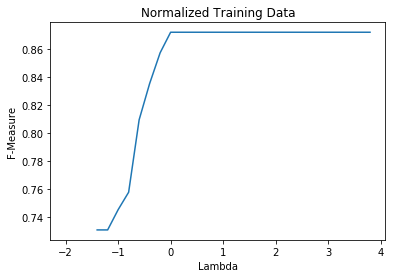

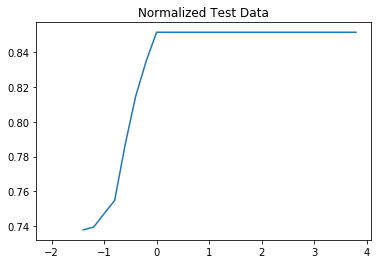

In [16]:
train_X = train_X / np.linalg.norm(train_X) # Normalization
test_X = test_X / np.linalg.norm(test_X) # Normalization

training_set = []
test_set = []
for lam_bda in np.arange(-2.0, 4.0, 0.2):
    logistic.fit(train_X, train_y, lam_bda=lam_bda)
    training_set.append([lam_bda, f_measure(logistic, train_X, train_y)])
    test_set.append([lam_bda, f_measure(logistic, test_X, test_y)])

plt.plot([v[0] for v in training_set], [v[1] for v in training_set])
plt.xlabel("Lambda")
plt.ylabel("F-Measure")
plt.title("Normalized Training Data")
plt.show()
plt.plot([v[0] for v in test_set], [v[1] for v in test_set])
plt.title("Normalized Test Data")
plt.show()

### Results
Graphs do not display values where f_measure returned nan.  
X Axis is Lambda  
Y Axis is F-Measure
#### Un-Normalized Data

Training Data Graph:
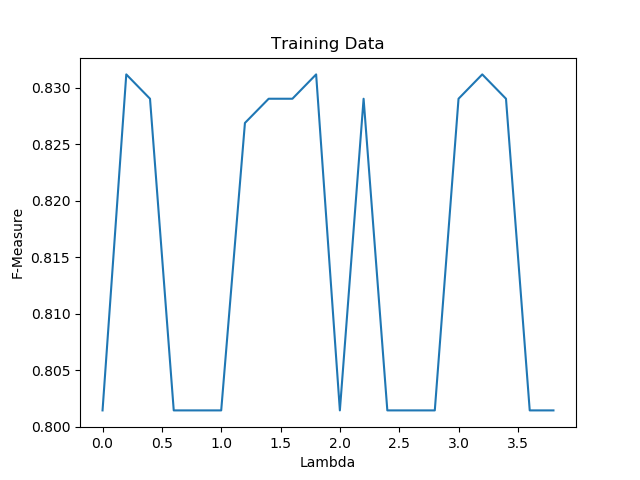
Test Data Graph
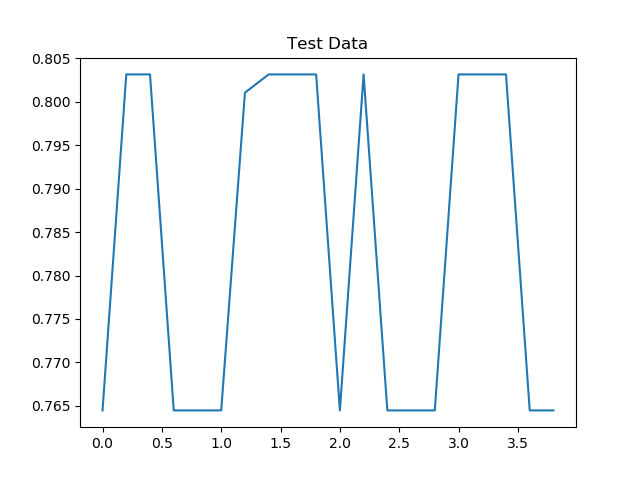

#### Normalized Data

Training Data Graph:
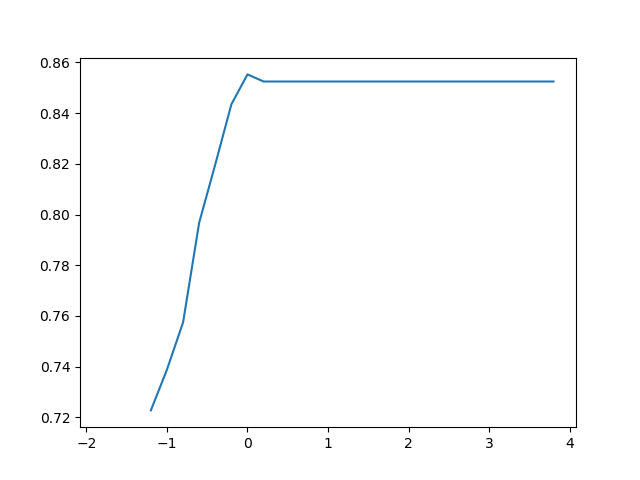

Test Data Graph:
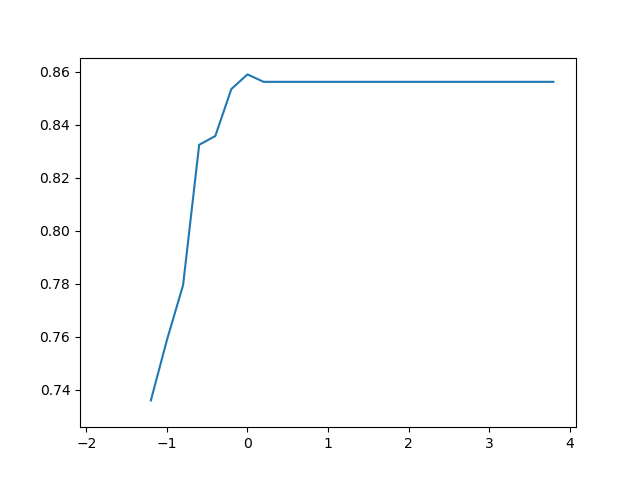

# Problem 3

In [5]:
from sklearn.datasets import load_digits
from sklearn.metrics import fowlkes_mallows_score
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation

## Load Data
data, target = load_digits(return_X_y=True)

# Processing Functions
# Conversion Function from cluster numbers to actual numbers
# THen relabels all numbers with actual numbers based on frequency
# Removes all data from clusters without any data. 
def conversion(matrix, labels):
    conversion = {}
    for t_i, cluster in enumerate(matrix):
        max_target = None
        for c_i, target in enumerate(cluster):
            if max_target is None or target > cluster[max_target]:
                max_target = c_i

            conversion[t_i] = max_target

    return [conversion[l] for l in labels if conversion[l] is not None]


# Create Confusion Matrix given clustering labels and target
def confusion_matrix(labels, target):
    matrix = [[0 for _ in range(10)] for __ in range(10)]

    for i, cluster in enumerate(labels):
        matrix[cluster][target[i]] += 1
    
    return matrix

# Displays confusion matrix with labels
def display_matrix(matrix):
    print('\t\tTarget', end='\n\t')
    [print("{:3d}".format(i), end=' ') for i in range(10)]
    print('', end='\n       ')
    [print("----", end='') for i in range(10)]
    yLabel = "Cluster"
    print('')
    for x in range(10):
        if x < len(yLabel):
            print(yLabel[x], end='   ')
        else:
            print('', end='    ')
        print(x, end=' | ')
        for y in range(10):
            print("{:3d}".format(matrix[x][y]), end=' ')
        print('')
        

## K-Means
Results seem to be heavily dependent on the random cluster initialization.
Sometimes has a score of 0.4 other times a score of 0.57.

In [6]:
# Convert to data format required for k-means
kmeans_data = [Point(val) for val in data]
k_means = kmeans(kmeans_data, 10)

# Create predictions for all labels that match clustering
labels = []
for point in data:
    labels.append(predict(k_means, Point(point)))

matrix = confusion_matrix(labels, target)

labels = conversion(matrix, labels)

# Only use first 500 values for fowlkes mallows because algorithm runs out of memory with more
print("K-Means Fowlkes-Mallows Score: ", fowlkes_mallows_score(target[:500], labels[:500]))
print("Grid for K-Means")

display_matrix(matrix)


K-Means Fowlkes-Mallows Score:  0.5195682688690324
Grid for K-Means
		Target
	  0   1   2   3   4   5   6   7   8   9 
       ----------------------------------------
C   0 |   4  30   8   9   0   6   0   1  19  72 
l   1 |   0 116   2  15   3  88   0  72  52  13 
u   2 |   4   1   6   0 172   1  15  16   7   0 
s   3 |   0   0   0 122   0  36   0   0   4  71 
t   4 |   0  26 143   4   0   0   0   0   8   2 
e   5 |   0   3   2   1   6   5   0  86  29   5 
r   6 |   0   0  16  31   0   0   0   1  21   1 
    7 |   5   0   0   0   0  29  39   3   9   5 
    8 |   0   6   0   1   0   1 126   0  13   0 
    9 | 165   0   0   0   0  16   1   0  12  11 


## Agglomerative Clustering

In [7]:
agglo = AgglomerativeClustering(n_clusters=10, linkage="ward")

clustering = agglo.fit(data)

labels = clustering.labels_
matrix = confusion_matrix(labels, target)
labels = conversion(matrix, labels)

print("Fowlkes-Mallows Score: ", fowlkes_mallows_score(target[:500], labels[:500]))
print("Confusion Matrix")

display_matrix(matrix)

Fowlkes-Mallows Score:  0.8411446738553939
Confusion Matrix
		Target
	  0   1   2   3   4   5   6   7   8   9 
       ----------------------------------------
C   0 |   0   0   0   0   0 179   0   0   0   2 
l   1 |   0   0   0 169   0   2   0   0   1 145 
u   2 |   0  27 166   0   0   0   0   0   4   0 
s   3 |   0   0   1   1   3   0   0 179   1  11 
t   4 |   0   0  10  13   0   0   1   0 165   2 
e   5 |   0   0   0   0 178   0   0   0   0   0 
r   6 |   0   0   0   0   0   1 180   0   0   0 
    7 | 178   0   0   0   0   0   0   0   0   0 
    8 |   0  59   0   0   0   0   0   0   1  20 
    9 |   0  96   0   0   0   0   0   0   2   0 


## Affinity Propagation Clustering
Used a preference of -50000 in order to have 10 clusters in results instead of 103 without any preference.
Takes a good chunk of time to run

In [8]:
aff = AffinityPropagation(preference=-50000)
clustering = aff.fit(data)

labels = clustering.labels_
matrix = confusion_matrix(labels, target)
labels = conversion(matrix, labels)

print("Fowlkes-Mallows Score: ", fowlkes_mallows_score(target[:500], labels[:500]))
print("Confusion Matrix")

display_matrix(matrix)

Fowlkes-Mallows Score:  0.6478463224426302
Confusion Matrix
		Target
	  0   1   2   3   4   5   6   7   8   9 
       ----------------------------------------
C   0 |   0   2   0   5   2 104   1   0  22   4 
l   1 |   0  52   0   0   9   1   0   0   6  17 
u   2 |   0   0  10 139   0   4   0   0  29   7 
s   3 |   1   0   0   0   0   7 172   0   0   0 
t   4 | 176   0   2   1   0   3   1   0   7   9 
e   5 |   0   0   9   6   6   2   0 170   5   8 
r   6 |   0 105   8   0  10   1   7   9  88   0 
    7 |   0  22 140   2   0   0   0   0   3   0 
    8 |   1   0   0   0 154   1   0   0   1   0 
    9 |   0   1   8  30   0  59   0   0  13 135 


# Problem 4

In [9]:
def load_data(fileName):
    data = []
    with open(fileName, 'r') as theFile:
        lines = theFile.read().split('\n')[1:]
        for i, l in enumerate(lines):
            current = []
            for attr in l.split(',')[:25]:
              try:
                current.append(float(attr))
              except:
                print(i, l, attr)
            data.append(current)

    return data

def f_measure(predictor, X, y):

  true_positive = 0
  false_positive = 0
  true_negative = 0
  false_negative = 0

  for i in range(len(X)):
    prediction = clf.predict([X[i]])
    if y[i] == 1:
      if prediction == 1:
        true_positive += 1
      else:
        false_positive += 1
    elif y[i] == 0:
      if prediction == 0:
        true_negative += 1
      else:
        false_negative += 1

  precision = true_positive / (true_positive + false_positive)
  recall = true_positive / (true_positive + false_negative)

  return (2 * precision * recall) / (precision + recall)


data = load_data("./data/chronic_kidney_disease_full_preprocessed.csv")

train_X = np.array([d[:len(d)-2] for d in data[:int(len(data) * .8)]])
train_y = np.array([d[len(d)-1] for d in data[:int(len(data) * .8)]])

test_X = np.array([d[:len(d)-2] for d in data[int(len(data) * 0.2):]])
test_y = np.array([d[len(d)-1] for d in data[int(len(data) * 0.2):]])


FileNotFoundError: [Errno 2] No such file or directory: './data/chronic_kidney_disease_full.1.csv'

## SVC Linear

In [51]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(train_X, train_y)

print("SVC linear training set f-measure: ", f_measure(clf, train_X, train_y))
print("SVC linear test set f-measure: ", f_measure(clf, test_X, test_y))

SVC linear training set f-measure:  0.9854368932038836
SVC linear test set f-measure:  0.9745454545454545


## SVC rbf

In [52]:
clf = SVC(kernel='rbf')
clf.fit(train_X, train_y)

print("SVC rbf training set f-measure: ", f_measure(clf, train_X, train_y))
print("SVC rbf test set f-measure: ", f_measure(clf, test_X, test_y))

SVC rbf training set f-measure:  1.0
SVC rbf test set f-measure:  0.7917888563049854


## Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(train_X, train_y)

print("Random Forest training set f-measure: ", f_measure(clf, train_X, train_y))
print("Random Forest test set f-measure: ", f_measure(clf, test_X, test_y))

Random Forest training set f-measure:  1.0
Random Forest test set f-measure:  0.9926470588235294
